<a href="https://colab.research.google.com/github/elnemr19/Text-Classification-RNN-/blob/main/text_Classification_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

i will use tensorflow version 2.10.0

In [39]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [40]:
!pip install tensorflow==2.10.0

## Import libraries

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
import string

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dropout, Dense, GlobalAveragePooling1D, Bidirectional, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score ,classification_report ,roc_curve, auc ,precision_recall_curve
from sklearn.model_selection import train_test_split

import pickle
import joblib

In [42]:
Data =pd.read_csv('/content/drive/MyDrive/Dataset/text_classification/bbc-text2.csv')
df =Data.copy()

In [43]:
pd.set_option('display.max_colwidth' ,150)
df.head(15)

,category,text
0,tech,tv future in the hands of viewers with home theatre systems plasma high-definition tvs and digital video recorders moving into the living room ...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers who is accused of overseeing an $11bn (£5.8bn) fraud never made accounting d...
2,sport,tigers wary of farrell gamble leicester say they will not be rushed into making a bid for andy farrell should the great britain rugby league cap...
3,sport,yeading face newcastle in fa cup premiership side newcastle united face a trip to ryman premier league leaders yeading in the fa cup third round. ...
4,entertainment,ocean s twelve raids box office ocean s twelve the crime caper sequel starring george clooney brad pitt and julia roberts has gone straight to ...
5,politics,howard hits back at mongrel jibe michael howard has said a claim by peter hain that the tory leader is acting like an attack mongrel shows labou...
6,politics,blair prepares to name poll date tony blair is likely to name 5 may as election day when parliament returns from its easter break the bbc s polit...
7,sport,henman hopes ended in dubai third seed tim henman slumped to a straight sets defeat in his rain-interrupted dubai open quarter-final against ivan ...
8,sport,wilkinson fit to face edinburgh england captain jonny wilkinson will make his long-awaited return from injury against edinburgh on saturday. wilk...
9,entertainment,last star wars not for children the sixth and final star wars movie may not be suitable for young children film-maker george lucas has said. h...


In [44]:
df.shape

(2225, 2)

In [45]:
df.isna().sum()

,0
category,0
text,0


In [46]:
df['category'].value_counts()

,count
category,
sport,511
business,510
politics,417
tech,401
entertainment,386


<Axes: ylabel='count'>

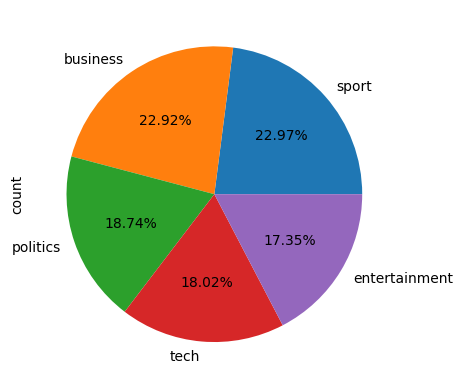

In [47]:
df['category'].value_counts().plot.pie(autopct='%2.2f%%')

## Pre-processing

In [48]:
embedding_dim =50
oov_tok ='<OOV>'
training_portion = .8
max_length =300

install important libraries to clean the text

In [49]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [50]:
punc =string.punctuation
st_words =stopwords.words('english')

In [51]:
st_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [52]:
punc

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

i will remove punctuation ,stopwords and convert text to lower

In [53]:
def clean (text):
  text =''.join([word.lower() for word in text if word not in punc])
  text =' '.join([word for word in text.split() if word not in st_words])

  return text

In [54]:
df['text'] =df['text'].apply(lambda x:clean(x))

In [55]:
df.head(10)

,category,text
0,tech,tv future hands viewers home theatre systems plasma highdefinition tvs digital video recorders moving living room way people watch tv radically di...
1,business,worldcom boss left books alone former worldcom boss bernie ebbers accused overseeing 11bn £58bn fraud never made accounting decisions witness told...
2,sport,tigers wary farrell gamble leicester say rushed making bid andy farrell great britain rugby league captain decide switch codes anybody else involv...
3,sport,yeading face newcastle fa cup premiership side newcastle united face trip ryman premier league leaders yeading fa cup third round game arguably hi...
4,entertainment,ocean twelve raids box office ocean twelve crime caper sequel starring george clooney brad pitt julia roberts gone straight number one us box offi...
5,politics,howard hits back mongrel jibe michael howard said claim peter hain tory leader acting like attack mongrel shows labour rattled opposition upbeat s...
6,politics,blair prepares name poll date tony blair likely name 5 may election day parliament returns easter break bbc political editor learned andrew marr s...
7,sport,henman hopes ended dubai third seed tim henman slumped straight sets defeat raininterrupted dubai open quarterfinal ivan ljubicic croatian eighth ...
8,sport,wilkinson fit face edinburgh england captain jonny wilkinson make longawaited return injury edinburgh saturday wilkinson played since injuring bic...
9,entertainment,last star wars children sixth final star wars movie may suitable young children filmmaker george lucas said told us tv show 60 minutes revenge sit...


In [56]:
labels =df['category']
sentence =df['text']

In [57]:
len(sentence)

2225

sentence

In [58]:
tokenizer =Tokenizer( oov_token= oov_tok )
tokenizer.fit_on_texts(sentence)
word_indx =tokenizer.word_index
vocab_size =len(word_indx)

sequence = tokenizer.texts_to_sequences(sentence)
sequence_padded =pad_sequences(sequence, padding= 'post', maxlen= max_length)

In [59]:
print((sentence[1]))
print((sequence[1]))
print((sequence_padded[1]))

worldcom boss left books alone former worldcom boss bernie ebbers accused overseeing 11bn £58bn fraud never made accounting decisions witness told jurors david myers made comments questioning defence lawyers arguing mr ebbers responsible worldcom problems phone company collapsed 2002 prosecutors claim losses hidden protect firm shares mr myers already pleaded guilty fraud assisting prosecutors monday defence lawyer reid weingarten tried distance client allegations cross examination asked mr myers ever knew mr ebbers make accounting decision aware mr myers replied ever know mr ebbers make accounting entry worldcom books mr weingarten pressed replied witness mr myers admitted ordered false accounting entries request former worldcom chief financial officer scott sullivan defence lawyers trying paint mr sullivan admitted fraud testify later trial mastermind behind worldcom accounting house cards mr ebbers team meanwhile looking portray affable boss admission pe graduate economist whatever 

In [60]:
word_indx['boss']

592

save tokenizer in specific direction

In [61]:
with open('/content/drive/MyDrive/Dataset/text_classification/text_tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

you can use this API to download and unzip glove

In [62]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip glove.6B.zip

In [63]:
# TARGET_DIR="/content/drive/MyDrive/Dataset/text_classification"

# # Download the GloVe embeddings to the specified directory
# !wget -P $TARGET_DIR http://nlp.stanford.edu/data/glove.6B.zip

# # Unzip the file to the specified directory
# !unzip $TARGET_DIR/glove.6B.zip -d $TARGET_DIR

In [64]:
embeddings_index = {}
with open('/content/drive/MyDrive/Dataset/text_classification/glove.6B.50d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

In [65]:
# Generating embeddings
embeddings_matrix = np.zeros((vocab_size+1, embedding_dim))
for word, i in word_indx.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector

labels

In [66]:
encoder =LabelEncoder()

df['category'] = encoder.fit_transform(df['category'])

joblib.dump(encoder, '/content/drive/MyDrive/Dataset/text_classification/label_encoder.pkl')

['/content/drive/MyDrive/Dataset/text_classification/label_encoder.pkl']

split data

In [67]:
X_train, X_test, y_train, y_test =train_test_split(sequence_padded, df['category'], random_state=42, test_size=.2)


print('train_sentence length :',len(X_train))
print('train_labels length :',len(y_train))
print('test_sentence length :',len(X_test))
print('test_labels length :',len(y_test))

train_sentence length : 1780
train_labels length : 1780
test_sentence length : 445
test_labels length : 445


##Model

In [77]:
model =Sequential([
    Embedding(vocab_size +1, embedding_dim, input_length= max_length, weights = [embeddings_matrix], trainable=False),

    Bidirectional(LSTM(128, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),

    Bidirectional(LSTM(32)),
    Dropout(0.5),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(5, activation='softmax')

])

model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 50)           1647850   
                                                                 
 bidirectional_6 (Bidirectio  (None, 300, 256)         183296    
 nal)                                                            
                                                                 
 dropout_8 (Dropout)         (None, 300, 256)          0         
                                                                 
 bidirectional_7 (Bidirectio  (None, 300, 128)         164352    
 nal)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 300, 128)          0         
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)              

In [78]:
history =model.fit(X_train, y_train, batch_size=32, epochs= 20, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/20
56/56 [==============================] - 153s 2s/step - loss: 1.0477 - accuracy: 0.6140 - val_loss: 0.4349 - val_accuracy: 0.9034
Epoch 2/20
56/56 [==============================] - 129s 2s/step - loss: 0.5084 - accuracy: 0.8556 - val_loss: 0.2714 - val_accuracy: 0.9281
Epoch 3/20
56/56 [==============================] - 127s 2s/step - loss: 0.3348 - accuracy: 0.9242 - val_loss: 0.2515 - val_accuracy: 0.9236
Epoch 4/20
56/56 [==============================] - 130s 2s/step - loss: 0.3407 - accuracy: 0.9185 - val_loss: 0.3792 - val_accuracy: 0.8899
Epoch 5/20
56/56 [==============================] - 131s 2s/step - loss: 0.2863 - accuracy: 0.9247 - val_loss: 0.2211 - val_accuracy: 0.9236
Epoch 6/20
56/56 [==============================] - 129s 2s/step - loss: 0.3064 - accuracy: 0.9253 - val_loss: 0.2220 - val_accuracy: 0.9303
Epoch 7/20
56/56 [==============================] - 171s 3s/step - loss: 0.2158 - accuracy: 0.9511 - val_loss: 0.2297 - val_accuracy: 0.9303
Epoch 8/20
56

In [79]:
model.save('/content/drive/MyDrive/Dataset/text_classification/text_classification_model.h5')

In [81]:
accur, loss =model.evaluate(X_test, y_test)

print('test accuracy is :',accur)
print('test loss is :',loss)

14/14 [==============================] - 14s 997ms/step - loss: 0.2211 - accuracy: 0.9236
test accuracy is : 0.22113054990768433
test loss is : 0.9235954880714417


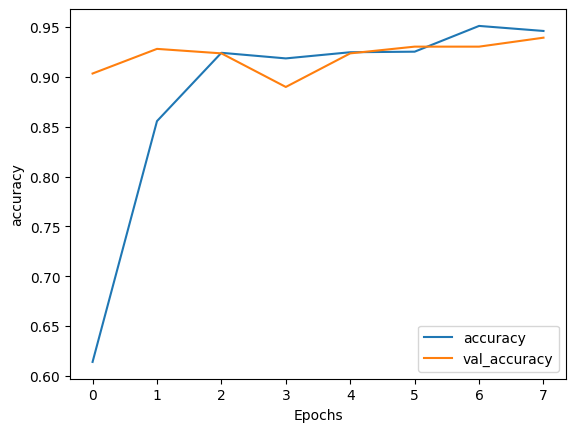

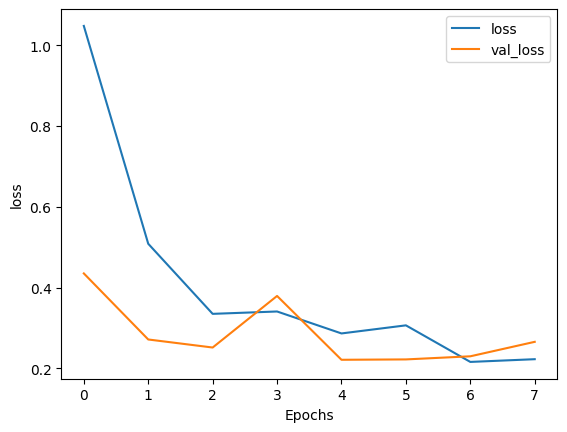

In [82]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+ string])
  plt.xlabel('Epochs')
  plt.ylabel(string)
  plt.legend([string,'val_'+ string ])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

14/14 [==============================] - 11s 477ms/step


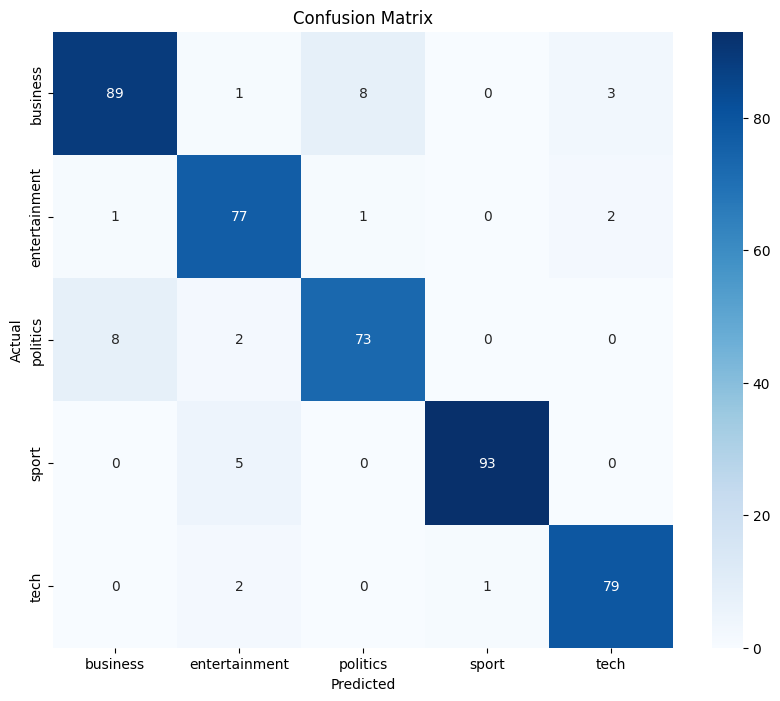

In [83]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


conf_matrix = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=np.unique(labels), yticklabels=np.unique(labels))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [84]:
class_report = classification_report(y_test, y_pred_classes, target_names=np.unique(labels))
print('Classification Report:\n', class_report)

Classification Report:
                precision    recall  f1-score   support

     business       0.91      0.88      0.89       101
entertainment       0.89      0.95      0.92        81
     politics       0.89      0.88      0.88        83
        sport       0.99      0.95      0.97        98
         tech       0.94      0.96      0.95        82

     accuracy                           0.92       445
    macro avg       0.92      0.92      0.92       445
 weighted avg       0.92      0.92      0.92       445



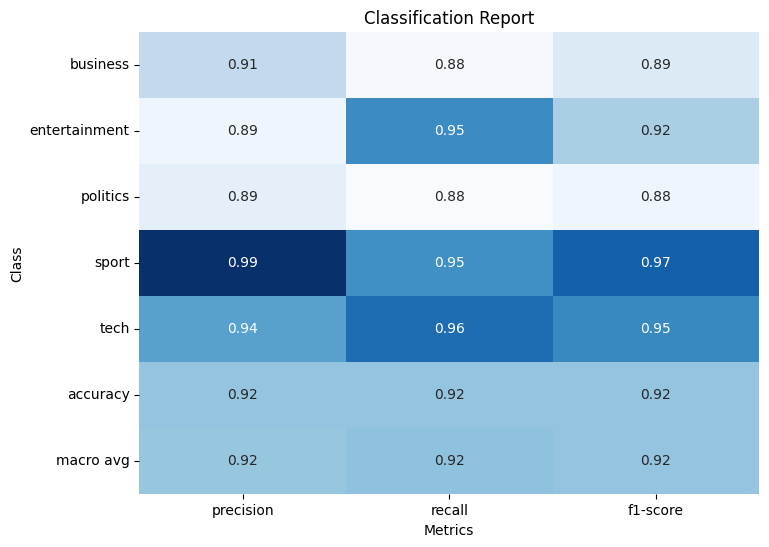

In [85]:
report = classification_report(y_test, y_pred_classes, target_names=np.unique(labels), output_dict=True)
report_df = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 6))
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', cbar=False)
plt.xlabel('Metrics')
plt.ylabel('Class')
plt.title('Classification Report' )
plt.show()

## Deployment

In [ ]:
!pip install tensorflow==2.10.0

In [75]:
!pip install gradio

In [94]:
import numpy as np
import nltk
from nltk.corpus import stopwords
import string
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import pickle
import joblib
import gradio as gr

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')

punc = string.punctuation
st_words = stopwords.words('english')
max_length = 300

# Load the model and necessary objects
model = load_model('/content/drive/MyDrive/Dataset/text_classification/text_classification_model.h5')

with open('/content/drive/MyDrive/Dataset/text_classification/text_tokenizer.pickle', 'rb') as handle:
    text_tokenizer = pickle.load(handle)

label_encoder = joblib.load('/content/drive/MyDrive/Dataset/text_classification/label_encoder.pkl')

def clean(text):
    text = ''.join([word.lower() for word in text if word not in punc])
    text = ' '.join([word for word in text.split() if word not in st_words])
    return text

def preprocess_text(text, tokenizer, max_length):
    sequence = tokenizer.texts_to_sequences([text])
    sequence_padded = pad_sequences(sequence, maxlen=max_length, padding='post')
    return sequence_padded

def classify_text(input_text):
    clean_text = clean(input_text)
    preprocessed_text = preprocess_text(clean_text, text_tokenizer, max_length)

    # Make prediction
    prediction = model.predict(preprocessed_text)
    predicted_class = np.argmax(prediction, axis=1)

    # Decode the predicted class
    predicted_label = label_encoder.inverse_transform(predicted_class)
    return predicted_label[0]

# Gradio interface
iface = gr.Interface(
    fn=classify_text,
    inputs=gr.Textbox(lines=2, placeholder="Enter text to classify..."),
    outputs=gr.Label(),
    title="Text Classification",
    description="Enter text to classify it into one of the predefined categories."
)

iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://a6b9390bab173b60db.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


In [ ]:
#'i always follow the news about artificial intelligence, and i love this field very much.'
#'Every Friday, I go to the zoo with my family, and we have a wonderful time together.'